<a href="https://colab.research.google.com/github/mohamedelziat50/Fruit-Recognition-MIU/blob/main/Fruit_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Processing project for fruit recognition using the Fruits-360 dataset.

### Import The Necessary Libraries

In [126]:
import kagglehub
import os, sys
import random
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

### Import The [Fruits-360 Dataset](https://www.kaggle.com/datasets/moltean/fruits) From Kaggle

In [127]:
# Load the dataset directly from kaggle (gives us the root path)
kaggle_dataset_path = kagglehub.dataset_download("moltean/fruits")

# Get the correct dataset path, by going inside the folders
dataset_path = os.path.join(kaggle_dataset_path, "fruits-360_100x100", "fruits-360")
print(f"Updated dataset path: {dataset_path}")

# Preview the contents of the path to double-check
print("\nFiles in the Dataset directory:", os.listdir(dataset_path))

Using Colab cache for faster access to the 'fruits' dataset.
Updated dataset path: /kaggle/input/fruits/fruits-360_100x100/fruits-360

Files in the Dataset directory: ['LICENSE', 'Training', 'README.md', 'Test']


### Store the Training & Testing paths independently

In [128]:
# Join the correct paths (checkout out the dataset's folder names on kaggle)
training_path = os.path.join(dataset_path, "Training")
testing_path = os.path.join(dataset_path, "Test")

# Display the Paths
print(f"Training Path: {training_path}")
print(f"Testing Path: {testing_path}\n")

# Check if directories exist
print("Training directory exists:", os.path.exists(training_path))
print("Testing directory exists:", os.path.exists(testing_path))

Training Path: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Training
Testing Path: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Test

Training directory exists: True
Testing directory exists: True


### Load the training dataset
#### Create a `Fruit` class that will store the fruit's image & label (Training Data)

In [129]:
class Fruit:
  # Constructor With a 2 properties: image & label
  def __init__(self, image, label):
      self.image = image
      self.label = label

  # Getter for image
  @property
  def image(self):
      return self._image

  # Setter for image
  @image.setter
  def image(self, image):
      self._image = image

  # Getter for label
  @property
  def label(self):
      return self._label

  # Setter for label
  @label.setter
  def label(self, label):
      self._label = label

#### Main function that properly fetches the training data & returns a fruits list

In [130]:
def get_categories(fruit_categories):
    # Store in a list of Fruit Objects that have image & label
    fruits = []

    # Loop over each category
    for category in fruit_categories:
        category_path = os.path.join(training_path, category)

        # Get a list of images in that category
        category_images = os.listdir(category_path)

        # Loop over the images (ONE Image per category for now)
        for image in category_images[:1]:
            image_path = os.path.join(category_path, image)

            # Read the image using OpenCV & store inside the Fruit class
            fruit = Fruit(cv.imread(image_path), category)
            fruits.append(fruit)

    return sorted(fruits, key=lambda fruit: fruit.label)


#### Get the fruit categories & fruit list objects

In [131]:
# Get a list of all fruit categories (subdirectories) in the training path
fruit_categories = os.listdir(training_path)

# Display how many labels/categories we have
print("Number of Fruit Categories (Labels):", len(fruit_categories), end="\n\n")

# Get a list of all fruits as `Fruit` objects with image & label
fruits = get_categories(fruit_categories)

# Display how many fruit images we have
print("Number of Fruit Images (Training Data):", len(fruits))

Number of Fruit Categories (Labels): 228

Number of Fruit Images (Training Data): 228


#### Display a random portion of the fruits using Matplotlib
##### ⚠️ Only converts BGR (OpenCV's default) to RGB when displaying with Matplotlib

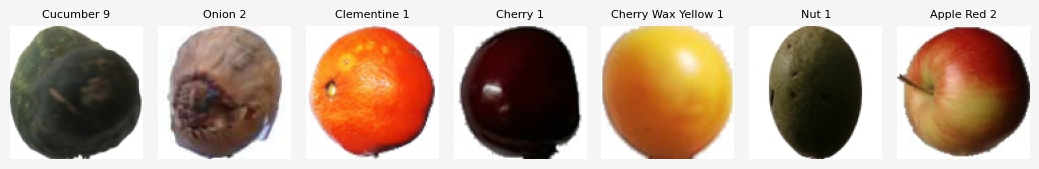

In [132]:
fruits_to_show = random.sample(fruits, 7)
rows, cols = 1, len(fruits_to_show)

plt.figure(figsize=(cols * 1.5, 2), facecolor="whitesmoke")

for index, fruit in enumerate(fruits_to_show):
    # Convert to RGB (Matplotlib) from BGR (OpenCV)
    rgb_image = cv.cvtColor(fruit.image, cv.COLOR_BGR2RGB)

    # Create subplot for this fruit
    plt.subplot(rows, cols, index + 1)  # index +1 because subplot indices start at 1

    # Show image
    plt.imshow(rgb_image)

    # Label on top
    plt.title(fruit.label, fontsize=8)

    # Remove ticks
    plt.axis('off')

plt.tight_layout()
plt.show()

### Image Enhancement & Analysis
#### Preview the Color Histogram (BGR Color Space) for a sample fruit.


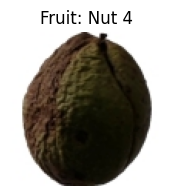

In [133]:
# We want the nuts image for now
fruit = None
for i, the_fruit in enumerate(fruits):
    if the_fruit.label == "Nut 4":
        fruit = fruits[i]
        break

# Convert BGR image to RGB for Matplotlib
rgb_image = cv.cvtColor(fruit.image, cv.COLOR_BGR2RGB)

plt.figure(figsize=(2, 2)) # Adjust the figure size (width, height in inches)
plt.imshow(rgb_image)
plt.title(f"Fruit: {fruit.label}")
plt.axis('off') # Hide axes for cleaner image display
plt.show()

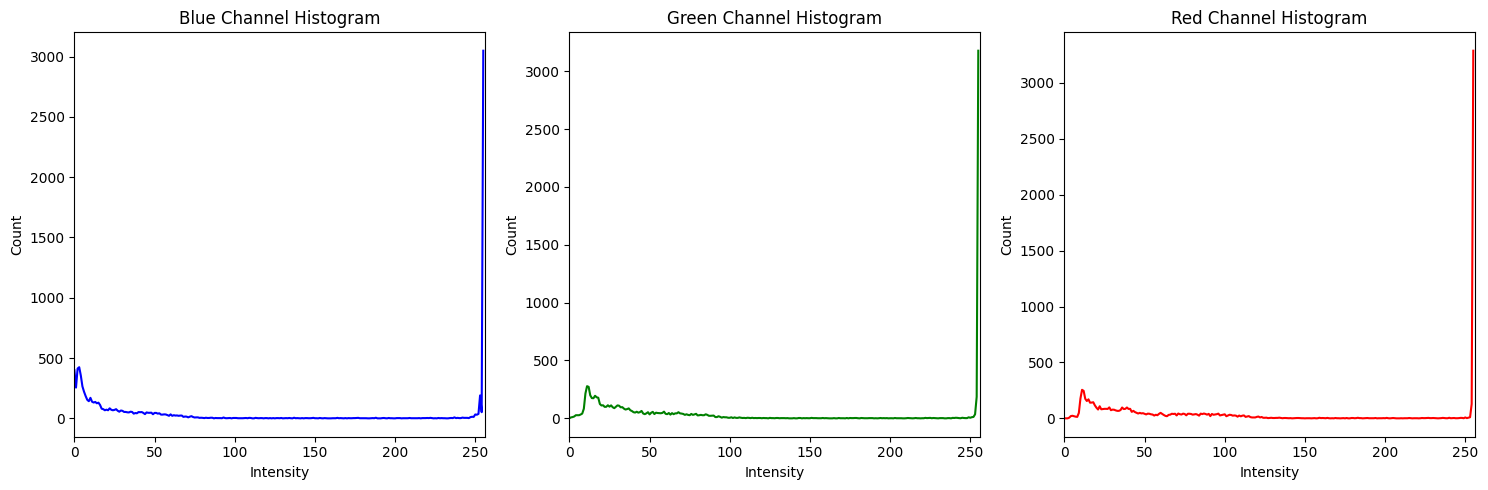

In [134]:
colors = ('b', 'g', 'r')
channel_names = ('Blue', 'Green', 'Red')

# Create figure for subplots
plt.figure(figsize=(15, 5))

# Iterate through channels and plot histograms using subplot indices
for i, (line_color, channel_name) in enumerate(zip(colors, channel_names)):
    plt.subplot(1, 3, i + 1)  # 1 row, 3 columns, current index
    histogram = cv.calcHist([fruit.image], [i], None, [256], [0, 256])
    plt.plot(histogram, color=line_color)
    plt.xlim([0, 256])
    plt.title(channel_name + ' Channel Histogram')
    plt.xlabel('Intensity')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

#### Convert BGR To HSV Color Space
##### Hue: Base Color of the pixel (0 to 360 Degrees in theory, but 180 in OpenCV)
##### Saturation: Purity Of the color (lower saturation means it's closer to gray, white, or black. High saturation means it a pure color, 0-100% - 0 to 255)
##### Value: Brightness of the color (Similar to grayscale: Between black & white, which side is it nearer to? 0 = black, 255 = white)

##### Conversion from RGB To HSV is crucial because the white background has near-zero saturation, while the colorful fruits have high saturation, making segmentation straightforward!

###### ⚠️ HSV Is not used to be displayed (will show weird colors). It's only used for processing on the saturation channel

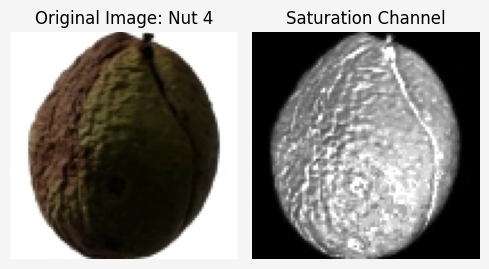


--- Saturation Channel Pixel Analysis ---
Minimum pixel value: 0
Maximum pixel value: 255

Sample saturation values:
  Pixel (15, 76): 152
  Pixel (34, 11): 4
  Pixel (3, 39): 18
  Pixel (28, 52): 151
  Pixel (37, 55): 163

White background pixels have low saturation (near 0)
Fruit region pixels have high saturation (near 255)
--- End Saturation Analysis ---


In [135]:
# Convert the BGR image to HSV
image_hsv = cv.cvtColor(fruit.image, cv.COLOR_BGR2HSV)
hue, saturation, value = cv.split(image_hsv) # Returns numpy arrays

# Display the original image
plt.figure(figsize=(5, 5), facecolor='whitesmoke')

# Original image (convert BGR to RGB for correct colors in matplotlib)
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(fruit.image, cv.COLOR_BGR2RGB))
plt.title(f"Original Image: {fruit.label}")
plt.axis('off')

# Saturation channel
plt.subplot(1, 2, 2)
plt.imshow(saturation, cmap='gray') # Show the colormap/intensities as a grayscale image
plt.title("Saturation Channel")
plt.axis('off')

plt.tight_layout()
plt.show()

# Print information about the saturation channel to showcase its pixel values
print("\n--- Saturation Channel Pixel Analysis ---")
print(f"Minimum pixel value: {np.min(saturation)}")
print(f"Maximum pixel value: {np.max(saturation)}")

# Print sample pixel values from saturation channel
print("\nSample saturation values:")
for i in range(5):
    row, col = random.randint(0, 99), random.randint(0, 99)
    print(f"  Pixel ({row}, {col}): {saturation[row, col]}")

print("\nWhite background pixels have low saturation (near 0)")
print("Fruit region pixels have high saturation (near 255)")
print("--- End Saturation Analysis ---")

#### Display the HSV Histogram

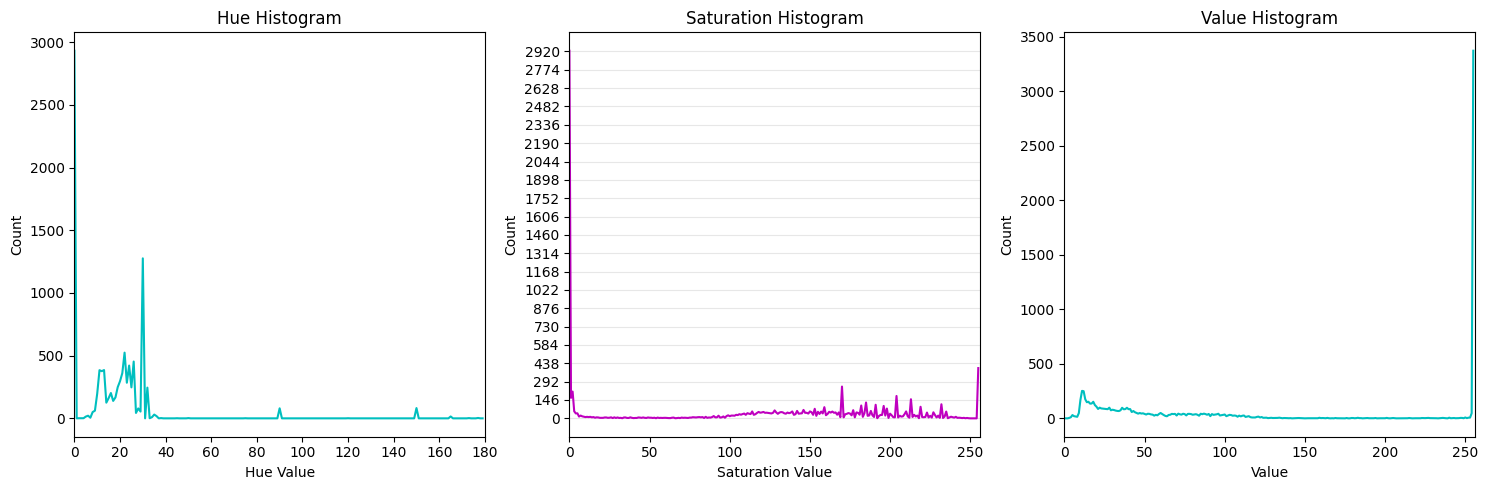


Notice (Saturation Histogram): Almost all intensities revolve around both ends (0 & 255), the others intensities have almost 0 count 


In [136]:
# Declare the histograms individually for a better view
hue_hist = cv.calcHist([hue], [0], None, [180], [0, 180]) # ([numpyarray], [channels(the index is 0 because we have one numpyarray)], [mask], [histogram_size], [range])
saturation_hist = cv.calcHist([saturation], [0], None, [256], [0, 256])
value_hist = cv.calcHist([value], [0], None, [256], [0, 256])

# Plot the histograms
plt.figure(figsize=(15, 5))

# Hue histogram
plt.subplot(1, 3, 1)  # 1 Row, 3 Columns, 1st Histogram
plt.title("Hue Histogram")
plt.plot(hue_hist, color='c')
plt.xlabel("Hue Value")
plt.ylabel("Count")
plt.xlim([0, 180])

# Saturation histogram
plt.subplot(1, 3, 2) # 1 Row, 3 Columns, 2nd Histogram
plt.title("Saturation Histogram")
plt.plot(saturation_hist, color='m')
plt.xlabel("Saturation Value")
plt.ylabel("Count")
plt.xlim([0, 256])

# Add detailed Y-axis ticks For Saturation Histogram
max_count = np.max(saturation_hist)
plt.yticks(np.arange(0, max_count + 1, max_count // 20))
plt.grid(axis='y', alpha=0.3)  # Add horizontal grid lines for better readability

# Value histogram
plt.subplot(1, 3, 3) # 1 Row, 3 Columns, 3rd Histogram
plt.title("Value Histogram")
plt.plot(value_hist, color='c')
plt.xlabel("Value")
plt.ylabel("Count")
plt.xlim([0, 256])

plt.tight_layout()
plt.show()

print("\nNotice (Saturation Histogram): Almost all intensities revolve around both ends (0 & 255), the others intensities have almost 0 count ")

### Image Segmentation
#### Apply a simple binary threshold to the saturation channel. Pixels with an intensity over 15 (Threshold) are set to 255 (white), while those 15 or below become 0 (black, the default value in 8-bit grayscale images).
#### To be safe and not get unintended pixels, we didn't use a lower threshold! Though, sometimes in very dark or very white fruits a very slight 'Under Segmentation' may happen and on a small amount of pixels.

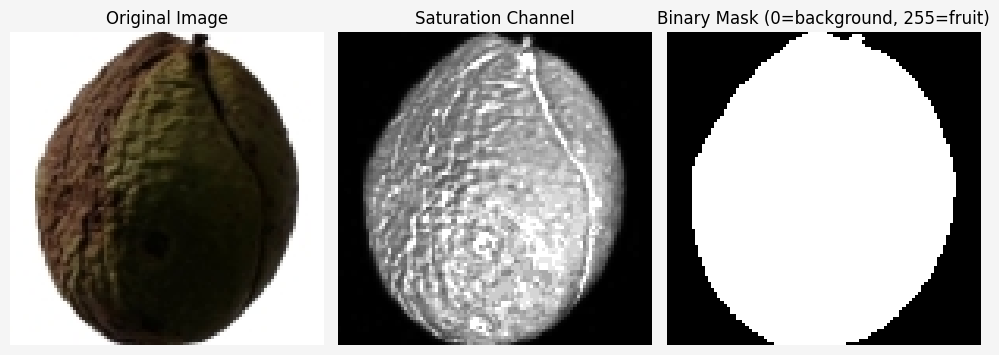


Sample binary mask values (0=background, 255=fruit):
  Pixel (2, 47): 255
  Pixel (56, 54): 255
  Pixel (24, 41): 255
  Pixel (66, 61): 255
  Pixel (89, 55): 255


In [137]:
_, fruit_segmented_mask = cv.threshold(saturation, 15, 255, cv.THRESH_BINARY)

# Display the binary mask (result of thresholding)
plt.figure(figsize=(10, 5), facecolor='whitesmoke')

# Show the original image
plt.subplot(1, 3, 1)
plt.imshow(cv.cvtColor(fruit.image, cv.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

# Show the Saturation channel
plt.subplot(1, 3, 2)
plt.imshow(saturation, cmap='gray') # Show the colormap/intensities as a grayscale image
plt.title("Saturation Channel")
plt.axis('off')

# Show the binary mask
plt.subplot(1, 3, 3)
plt.imshow(fruit_segmented_mask, cmap='gray') # Show the colormap/intensities as a grayscale image
plt.title("Binary Mask (0=background, 255=fruit)")
plt.axis('off')

plt.tight_layout()
plt.show()

# Also print some sample pixel values from the binary mask
print("\nSample binary mask values (0=background, 255=fruit):")
for i in range(5):
    row, col = random.randint(0, 99), random.randint(0, 99)
    print(f"  Pixel ({row}, {col}): {fruit_segmented_mask[row, col]}")

#### Now let's visualize the segmented image with it's color
##### Step-by-step logic:
1. Take pixel from first image (fruit.image)

2. Take same pixel from second image (also fruit.image - same image!)

3. Check the mask value at that position (Based on the OpenCV function):
    - Apply mask to control which pixels survive the AND operation

    - If mask = 255 (white, e.g anything non-zero): KEEP the pixel value from the image

    - If mask = 0 (black): SET the pixel to 0 (black)

##### OpenCV Design Note:
The bitwise_and() function requires TWO images even when you only want to apply a mask to ONE image. Using the same image twice is just a workaround because OpenCV doesn't have a simpler apply_mask() function.

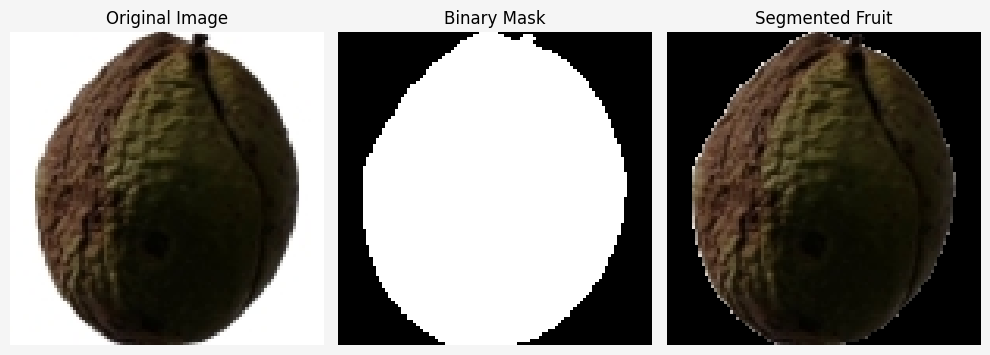

In [138]:
# Create a figure with 3 subplots
plt.figure(figsize=(10, 5), facecolor='whitesmoke')

# 1. Original image
plt.subplot(1, 3, 1)
plt.imshow(cv.cvtColor(fruit.image, cv.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

# 2. Binary mask
plt.subplot(1, 3, 2)
plt.imshow(fruit_segmented_mask, cmap='gray')
plt.title("Binary Mask")
plt.axis('off')

# 3. Showcase the segmented fruit (with it's colors) through the mask
# Create black image (all zeros)
fruit_black = cv.bitwise_and(fruit.image, fruit.image, mask=fruit_segmented_mask)
plt.subplot(1, 3, 3)
plt.imshow(cv.cvtColor(fruit_black, cv.COLOR_BGR2RGB))
plt.title("Segmented Fruit")
plt.axis('off')

plt.tight_layout()
plt.show()

#### Generalized the process of segmentation (all details needed have been explained on the sample fruit above!)


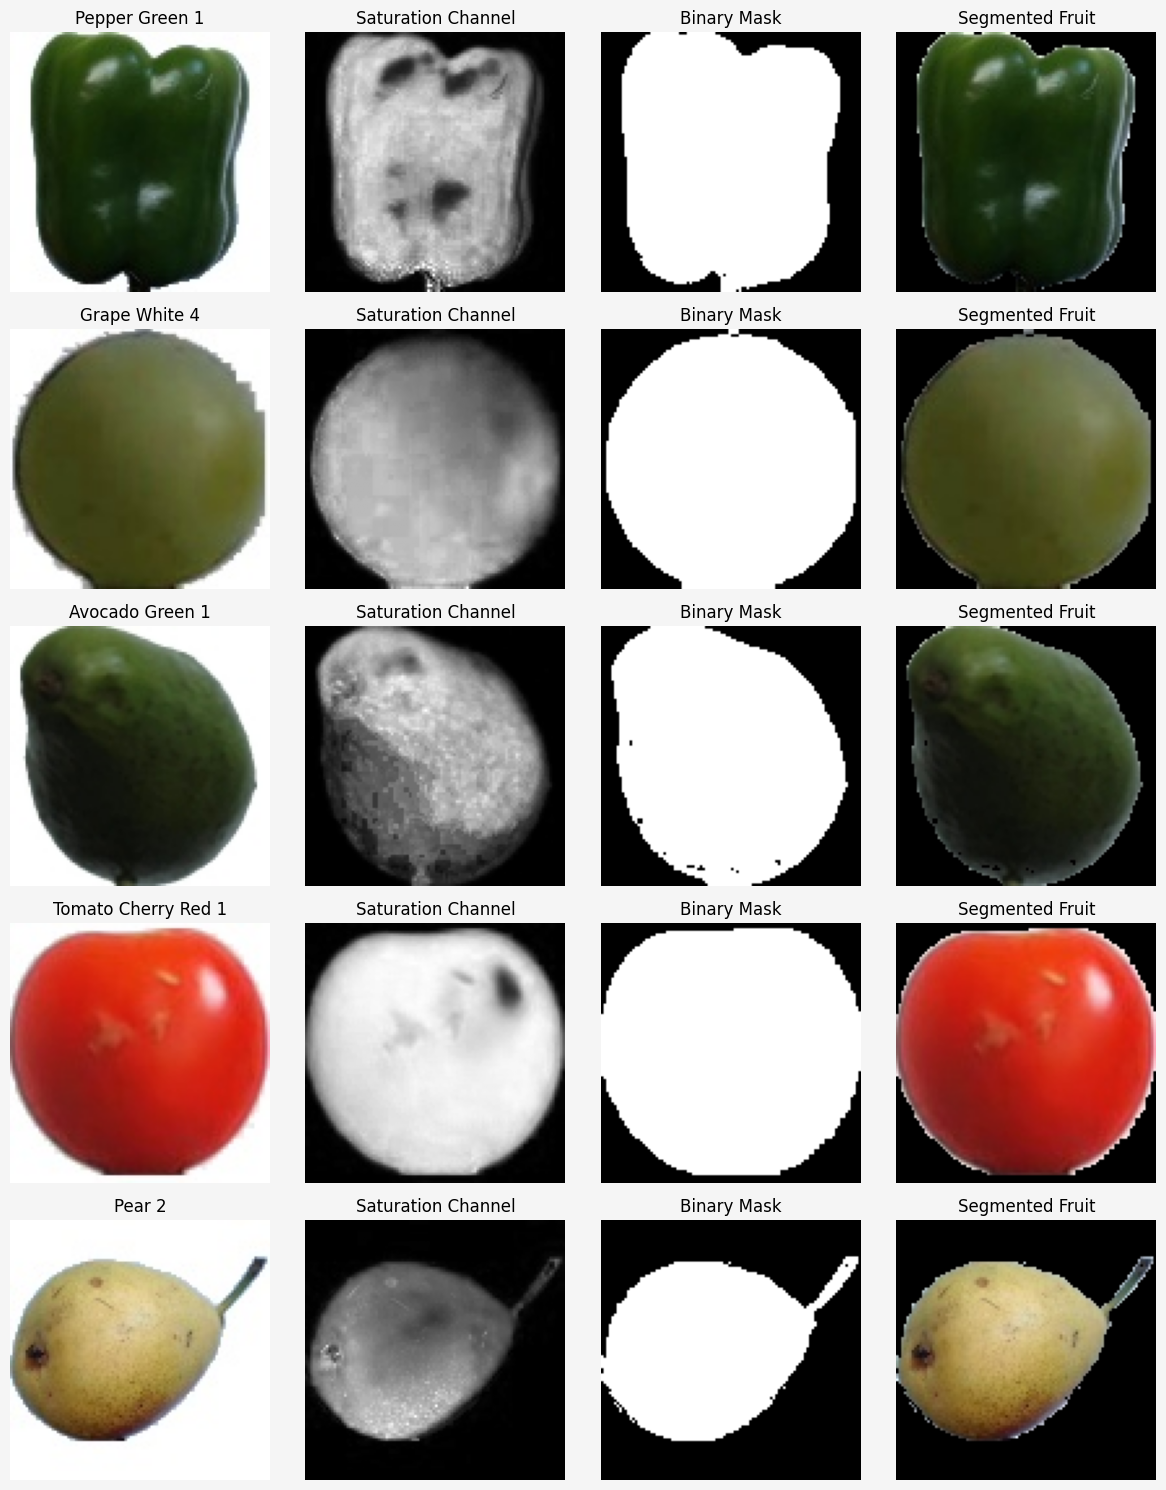

In [139]:
def test_segmentation(fruits, no_of_fruits=5):
    # Create one BIG figure with all results
    plt.figure(figsize=(12, 3 * no_of_fruits), facecolor="whitesmoke")  # number of fruits rows, 4 columns

    for index, fruit in enumerate(random.sample(fruits, no_of_fruits)):
        # Convert the BGR image to HSV
        image_hsv = cv.cvtColor(fruit.image, cv.COLOR_BGR2HSV)
        hue, saturation, value = cv.split(image_hsv) # Returns numpy arrays

        # Segment the image through simple global thresholding
        _, segmented_image = cv.threshold(saturation, 15, 255, cv.THRESH_BINARY)

        # Then visualize the segmentation through matplotlib
        visualize_segmentation(no_of_fruits, fruit, saturation, segmented_image, index)

    plt.tight_layout()
    plt.show()

def visualize_segmentation(no_of_fruits, fruit, saturation, segmented_image, index):
    # Show the original image
    plt.subplot(no_of_fruits, 4, index * 4 + 1) # rows, columns, position in the subplot starting from index 1
    plt.imshow(cv.cvtColor(fruit.image, cv.COLOR_BGR2RGB))
    plt.title(f"{fruit.label}")
    plt.axis('off')

    # Show the Saturation channel
    plt.subplot(no_of_fruits, 4, index * 4 + 2)
    plt.imshow(saturation, cmap='gray') # Show the colormap/intensities as a grayscale image
    plt.title("Saturation Channel")
    plt.axis('off')

    # Show the binary mask
    plt.subplot(no_of_fruits, 4, index * 4 + 3)
    plt.imshow(segmented_image, cmap='gray') # Show the colormap/intensities as a grayscale image
    plt.title("Binary Mask")
    plt.axis('off')

    # Showcase the segmented fruit (with it's colors) through the mask
    # Create black image (all zeros)
    fruit_black = cv.bitwise_and(fruit.image, fruit.image, mask=segmented_image)
    plt.subplot(no_of_fruits, 4, index * 4 + 4)
    plt.imshow(cv.cvtColor(fruit_black, cv.COLOR_BGR2RGB))
    plt.title("Segmented Fruit")
    plt.axis('off')

test_segmentation(fruits)

### Image Description & Feature Extraction

#### 4 Features & Descriptors:
- Area (Total no. of white pixels in the segmented mask/fruit)
    - Region-based descriptor because we used a region-based segmentation method (threshold)
    - Completly valid to use since our dataset doesn't face a "scale problem" (unequal capturing distances)
- Average Hue (What is the dominant color?)
- Average Saturation (Is the average saturation a pure color?)
- Average Value (Is the average value, bright or dark?)

Possibly will have to make one big function that extracts features along side the segmentation to save memory & processing time

#### For now we'll continue working on the 'sample' fruit that we explained on:
- fruit -> sample fruit object
- fruit_segmented_mask -> segmented mask

In [140]:
# Returns: [area, avg_hue, avg_sat, avg_val] -> Feature vector!
def extract_features(fruit_image):
    ...


#### 1. Area

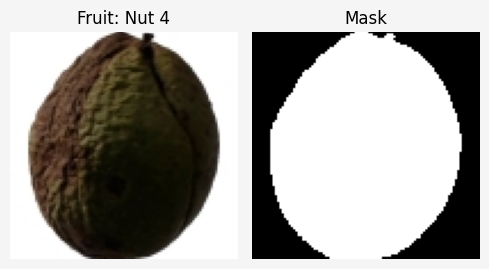


--- Mask Preprocessing ---
Sample Row: (0=background, 255=fruit)
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0 255 255 255 255 255 255   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]

Mask datatype: <class 'numpy.ndarray'>
Mask shape (rows, columns): (100, 100)
Mask size (total pixels): 10000
Area = 6436
--- End Mask Preprocessing ---


In [158]:
# Showcase fruit & mask using matplotlib
plt.figure(figsize=(5, 5), facecolor="whitesmoke")

# Fruit
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(fruit.image, cv.COLOR_BGR2RGB))
plt.title(f"Fruit: {fruit.label}")
plt.axis('off')

# Mask
plt.subplot(1, 2, 2)
plt.imshow(fruit_segmented_mask, cmap='gray') # Show the colormap/intensities as a grayscale image
plt.title("Mask")
plt.axis('off')

plt.tight_layout()
plt.show()

# Analyze the mask & adjust!
print("\n--- Mask Preprocessing ---")

# Display a sample row (1st row)
print("Sample Row: (0=background, 255=fruit)\n", fruit_segmented_mask[0])

print("\nMask datatype:", type(fruit_segmented_mask)) # Numpy Array
print("Mask shape (rows, columns):", fruit_segmented_mask.shape) # It's a 2D Array
print("Mask size (total pixels):", fruit_segmented_mask.size)

# Count the total no. of segmented pixels only (255)
area = np.count_nonzero(fruit_segmented_mask) # Counts True values
print("Area =", area)
print("--- End Mask Preprocessing ---")


2. Average Hue (What is the dominant color?)